## 인공지능 과제
### 학번: 201533812 이름: 이상민
### 제출일: 2020년 06월 23일(화)
---

# <center> 5.4	Visualizing what convnets learn </center>
> 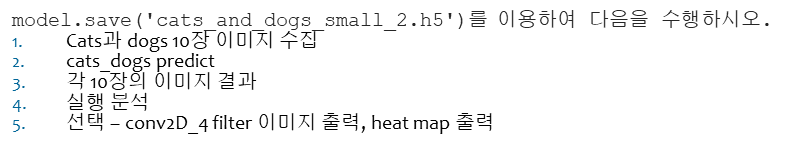

In [ ]:
# 0. cats_and_dogs_small_2.h5 불러오기

import keras
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')

model.summary()

# 1. Cats and dogs 이미지 10장 수집

import os, shutil
import matplotlib.pyplot as plt
import numpy as np
from keras import models
from keras.preprocessing import image

cat_image_list = []
cat_image_tensor_list = []

dog_image_list = []

dir_path = './datasets/pictures/'
cat_img_path = dir_path + 'cats/cat_'
dog_img_path = dir_path + 'dogs/dog_'


layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)


# 이미지가 10개이므로, 반복횟수를 10으로 지정.
# 이미지의 개수가 가변하다면, 변수는 바꾸어 지정해야 함.
for i in range(1, 11):
    
    img_num = "{0:02d}".format(i)
    img_path = cat_img_path + img_num + '.jpg'
    
    # cat image path를 리스트에 저장.
    cat_image_list.append(img_path)
    
    img = image.load_img(img_path, target_size=(150,150))
    plt.title(img_path[-10:])
    plt.imshow(img)
    plt.show()

print("="*50)
    
for i in range(1, 11):
    
    img_num = "{0:02d}".format(i)
    img_path = dog_img_path + img_num + '.jpg'
    
    # dog image path를 리스트에 저장.
    dog_path = dog_img_path + img_num + '.jpg'
    dog_image_list.append(dog_path)
    
    img = image.load_img(img_path, target_size=(150,150))
    plt.title(img_path[-10:])
    plt.imshow(img)
    plt.show()


# 2. cats and dogs predict

from keras.preprocessing import image
import numpy as np

cat_results = []
for img_path in cat_image_list:
    # 150 x 150 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환됩니다
    img = image.load_img(img_path, target_size=(150, 150))

    # (150, 150, 3) 크기의 넘파이 float32 배열
    x = image.img_to_array(img)
    
    # 차원을 추가하여 (1, 150, 150, 3) 크기의 배치로 배열을 변환합니다
    x = np.expand_dims(x, axis=0)

    # 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
    x = x / 255.

    preds = model.predict(x)
    
    cat_results.append(preds)
    
dog_results = []
for img_path in dog_image_list:
    # 150 x 150 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환됩니다
    img = image.load_img(img_path, target_size=(150, 150))

    # (150, 150, 3) 크기의 넘파이 float32 배열
    x = image.img_to_array(img)

    # 차원을 추가하여 (1, 150, 150, 3) 크기의 배치로 배열을 변환합니다
    x = np.expand_dims(x, axis=0)

    # 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
    x = x / 255.
    
    preds = model.predict(x)
    
    dog_results.append(preds)

# 3. 각 10장의 이미지에 대한 예측 결과

cat_results = [float(i) for i in cat_results]
dog_results = [float(i) for i in dog_results]
xlabel = [i for i in range(1, 11)]
plt.plot(xlabel, cat_results)
plt.plot(xlabel, dog_results, 'r')
plt.title("Cats and dogs predict result")
plt.xlabel("Count")
plt.ylabel("Accuracy")
plt.legend(['Cat', 'Dog'])
plt.show()

## 정확도 시각화

붉은색은 dog에 대한 예측 결과이며, 파란색은 cat에 대한 예측 결과이다.  
그래프를 분석해봤을 때,  
sigmoid로 분류를 한 결과값이  
`0` 에 가까울 수록 `고양이`이며,  
`1` 에 가까울 수록 `강아지`라는 것을 알 수 있다.  
또한, 해당 모델이 고양이를 잘 학습하지 못했다는 사실을 알 수 있다.  

# 4. 실행 분석

### cats_and_dogs_small_2.h5  
1) Dogs
- 여러 종에 대한 훈련이 잘 되었고, 좋은 예측값을 얻어냄.  

2) Cats 
- 특정 종의 고양이만 분석이 되었다. (4 ~ 8번 사진)
- 1, 3, 10번 사진 같은 경우, 확실하게 강아지라고 분류를 했기 때문에, 현재로서는 좋지 않은 성능이라고 판단할 수 있다.
    

# 5. conv2d_ 4 filter 이미지 출력, heatmap 출력

import cv2
from keras.applications import VGG16
from keras import backend as K

layer_name = 'conv2d_8'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# gradients 함수가 반환하는 텐서 리스트(여기에서는 크기가 1인 리스트)에서 첫 번째 텐서를 추출합니다
grads = K.gradients(loss, model.input)[0]

# 0 나눗셈을 방지하기 위해 1e–5을 더합니다
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])

# 테스트:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

# 잡음이 섞인 회색 이미지로 시작합니다
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 업데이트할 그래디언트의 크기
step = 1.
for i in range(40):   # 경사 상승법을 40회 실행합니다
    # 손실과 그래디언트를 계산합니다
    loss_value, grads_value = iterate([input_img_data])
    # 손실을 최대화하는 방향으로 입력 이미지를 수정합니다
    input_img_data += grads_value * step

def deprocess_image(x):
    # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화합니다
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1]로 클리핑합니다
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 배열로 변환합니다
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의합니다
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트를 계산합니다
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환합니다
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작합니다
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계 실행합니다
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

## 4 번째 필터 (layer_name = conv2d_8) 이미지

layer_name = 'conv2d_8'
size = 64
margin = 5

# 결과를 담을 빈 (검은) 이미지
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')
for i in range(8):  # results 그리드의 행을 반복합니다
    for j in range(8):  # results 그리드의 열을 반복합니다
        # layer_name에 있는 i + (j * 8)번째 필터에 대한 패턴 생성합니다
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

        # results 그리드의 (i, j) 번째 위치에 저장합니다
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

# results 그리드를 그립니다
plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.show()

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions


K.clear_session()

# 이전 모든 예제에서는 최상단의 완전 연결 분류기를 제외했지만 여기서는 포함합니다
model = VGG16(weights='imagenet')

def save_heatmap(image_list):
    
    for img_path in image_list:
        # 224 × 224 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환됩니다
        img = image.load_img(img_path, target_size=(224, 224))

        # (224, 224, 3) 크기의 넘파이 float32 배열
        x = image.img_to_array(img)

        # 차원을 추가하여 (1, 224, 224, 3) 크기의 배치로 배열을 변환합니다
        x = np.expand_dims(x, axis=0)

        # 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
        x = preprocess_input(x)

        preds = model.predict(x)
        # 가장 높은 점수를 보이는 두 가지 종만 출력합니다.
        # print("Predicted:", decode_predictions(preds, top=3)[0][:2])
        pred_index = np.argmax(preds[0])
        # print(img_path[-10:], ": ", pred_index)

        feature_output = model.output[:, pred_index]

        # VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
        last_conv_layer = model.get_layer('block5_conv3')

        # block5_conv3의 특성 맵 출력에 대한 예측 클래스의 그래디언트
        grads = K.gradients(feature_output, last_conv_layer.output)[0]

        # 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

        # 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

        # 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
        pooled_grads_value, conv_layer_output_value = iterate([x])

        # 예측 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
        for i in range(512):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        # 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        ###############################################################################
        # opencv 모듈을 사용하여 히트맵 결과 사진 저장!!

        # cv2 모듈을 사용해 원본 이미지를 로드합니다
        img = cv2.imread(img_path)

        # heatmap을 원본 이미지 크기에 맞게 변경합니다
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        # heatmap을 RGB 포맷으로 변환합니다
        heatmap = np.uint8(255 * heatmap)

        # 히트맵으로 변환합니다
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # 0.4는 히트맵의 강도입니다
        superimposed_img = heatmap * 0.4 + img

        result_dir_path = './datasets/pictures/heatmap/'

        result_file_path = result_dir_path + img_path[-10:]

        # 디스크에 이미지를 저장합니다
        cv2.imwrite(result_file_path, superimposed_img)
        
        print(img_path[-10:], "Save succeeded !!")


save_heatmap(dog_image_list)
save_heatmap(cat_image_list)

### 히트맵이 적용된 모든 사진

heatmap_dir_path = dir_path + 'heatmap/'
file_list = os.listdir(heatmap_dir_path)

for file in file_list:
    result = plt.imread(heatmap_dir_path + file)
    plt.title(file)
    plt.imshow(result)
    plt.show()